# Fantasy Premier League Score Predictor using Deep Neural Networks

This document details the process of building and evaluating a Deep Neural Network (DNN) model to predict Fantasy Premier League (FPL) scores using historical data. The project involves data loading, preprocessing, model construction using the Keras Functional API, training, evaluation, and visualization of results.

## Load the data

### Subtask:
Load the data from the "/content/fpl_training.csv.zip" file into a pandas DataFrame.

**Reasoning**:
Load the data from the specified CSV file into a pandas DataFrame and display the head and info to inspect the data and its types.

In [5]:
import pandas as pd

df = pd.read_csv('/content/fpl_training.csv.zip')
display(df.head())

,element,round,assists,bonus,bps,clean_sheets,value,creativity,total_points,goals_conceded,...,npxGA_opponent_team,deep_opponent_team,deep_allowed_opponent_team,scored_opponent_team,missed_opponent_team,npxGD_opponent_team,ppda_att_opponent_team,ppda_def_opponent_team,ppda_allowed_att_opponent_team,ppda_allowed_def_opponent_team
0,454,1,0.10863,0.32589,17.788171,0.298733,5.5,0.0,3.611949,1.357876,...,1.094252,9.315789,5.105263,1.552632,1.394737,0.239271,213.236842,25.0,272.026316,27.0
1,454,2,0.00000,0.00000,0.000000,0.000000,5.5,0.0,0.000000,0.000000,...,1.911050,3.000000,4.000000,1.000000,3.000000,-1.388203,351.000000,24.0,263.000000,25.0
2,454,3,0.00000,0.00000,0.000000,0.000000,5.4,0.0,0.000000,0.000000,...,0.549491,9.000000,3.000000,4.000000,1.000000,0.861319,208.000000,44.0,253.000000,19.0
3,454,4,0.00000,0.00000,0.000000,0.000000,5.4,0.0,0.000000,0.000000,...,1.271540,8.000000,11.000000,1.000000,3.000000,-0.193790,286.000000,29.0,204.000000,29.0
4,454,5,0.00000,0.00000,0.000000,0.000000,5.4,0.0,0.000000,0.000000,...,0.986511,4.000000,8.000000,0.000000,1.000000,0.496959,224.000000,21.0,130.000000,19.0


## Preprocess the data

### Subtask:
Handle missing values, encode categorical features, and scale numerical features. Split the data into training and testing sets.

**Reasoning**:
Check for missing values, handle them, encode categorical features, scale numerical features, separate the target variable, and split data into training and testing sets using scikit-learn.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

# 1. Handle missing values (using median imputation for simplicity, consider other methods if needed)
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# 2. Identify categorical and numerical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

# Remove the target variable from numerical features
target = 'total_points'
if target in numerical_features:
    numerical_features.remove(target)
elif target in categorical_features:
    categorical_features = categorical_features.drop(target)

# 3. Apply one-hot encoding and standard scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Separate target variable
X = df.drop(target, axis=1)
y = df[target]

# Create a pipeline that first preprocesses the data and then could be used for modeling
X_processed = preprocessor.fit_transform(X)

# 5. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Original data shape:", df.shape)
print("Processed data shape:", X_processed.shape)
print("Training data shape (features):", X_train.shape)
print("Testing data shape (features):", X_test.shape)
print("Training data shape (target):", y_train.shape)
print("Testing data shape (target):", y_test.shape)

/tmp/ipython-input-962693367.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-962693367.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

Original data shape: (71597, 64)
Processed data shape: (71597, 2114)
Training data shape (features): (57277, 2114)
Testing data shape (features): (14320, 2114)
Training data shape (target): (57277,)
Testing data shape (target): (14320,)


## Build the dnn model

### Subtask:
Create a deep neural network with 4 hidden layers using the Keras Functional API.

**Reasoning**:
Create a deep neural network with 4 hidden layers using the Keras Functional API and print the model summary to visualize the architecture.

In [7]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the input layer
input_layer = Input(shape=(X_train.shape[1],))

# Create the hidden layers
hidden_layer_1 = Dense(128, activation='relu')(input_layer)
hidden_layer_2 = Dense(64, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(32, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(16, activation='relu')(hidden_layer_3)

# Define the output layer
output_layer = Dense(1)(hidden_layer_4) # Single neuron for regression

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2114)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       270,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,601 (1.07 MB)

 Trainable params: 281,601 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

## Choose and compile the model

### Subtask:
Select an appropriate loss function (e.g., Poisson or RMSE) and optimizer, and compile the model.

**Reasoning**:
Import necessary components from TensorFlow and Keras, choose an appropriate loss function (Mean Squared Error for regression) and optimizer (Adam), and compile the Keras model.

In [8]:
import tensorflow as tf

# Choose an appropriate loss function
# 'mean_squared_error' (RMSE) is a common choice for regression.
# 'Poisson' loss can be suitable for count data, but FPL points are not strictly counts and can be negative.
# RMSE is generally a safer choice for this type of regression problem.
loss_function = 'mean_squared_error'

# Choose an appropriate optimizer
optimizer = 'adam' # Adam is a popular and effective optimizer

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function)

print(f"Model compiled with optimizer: {optimizer} and loss function: {loss_function}")

Model compiled with optimizer: adam and loss function: mean_squared_error


## Train the model

### Subtask:
Train the model on the training data.

**Reasoning**:
Train the compiled Keras model `model` using the training data `X_train` and `y_train`, including validation data (`X_test`, `y_test`) to monitor performance and detect overfitting over 50 epochs.

In [9]:
# Define training parameters
epochs = 50
batch_size = 32

# Train the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))

Epoch 1/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 1.0579 - val_loss: 0.7517
Epoch 2/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.1848 - val_loss: 0.2738
Epoch 3/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.2268 - val_loss: 0.1140
Epoch 4/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.1762 - val_loss: 0.1393
Epoch 5/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.1725 - val_loss: 0.0859
Epoch 6/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.0701 - val_loss: 0.3348
Epoch 7/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.1735 - val_loss: 0.1478
Epoch 8/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.1374 - val_loss: 0.0995
Epoch 9/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.1414 - val_loss: 0.1017
Epoch 10/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.1753 - val_loss: 0.0980
Epoch 11/50
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0945 - val_loss: 0.2930
Epoch 12/50
1790/17

## Evaluate the model

### Subtask:
Evaluate the model's performance on the testing data using appropriate metrics.

**Reasoning**:
Evaluate the trained Keras model `model` using the testing data `X_test` and `y_test` to assess its performance on unseen data using Mean Squared Error (MSE).

In [10]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss (Mean Squared Error): {loss:.4f}")

Test Loss (Mean Squared Error): 0.1448


## Make predictions

### Subtask:
Use the trained model to make predictions on new data.

**Reasoning**:
Use the trained model to make predictions on the testing data `X_test` and flatten the output for easier handling.

In [11]:
# Make predictions on the test data
predictions = model.predict(X_test).flatten()

# Display the first 10 predictions and actual values
for i in range(10):
    print(f"Predicted: {predictions[i]:.4f}, Actual: {y_test.iloc[i]:.4f}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Predicted: 1.9751, Actual: 2.0000
Predicted: 6.8654, Actual: 7.0000
Predicted: 1.0141, Actual: 1.0000
Predicted: 0.0110, Actual: 0.0000
Predicted: 0.0160, Actual: 0.0000
Predicted: 0.0164, Actual: 0.0000
Predicted: -0.1310, Actual: 0.0000
Predicted: 2.0022, Actual: 2.0000
Predicted: 0.0164, Actual: 0.0000
Predicted: 5.9557, Actual: 6.0000


## Visualize Actual vs Predicted Values

### Subtask:
Create a scatter plot to visualize the relationship between actual and predicted FPL scores.

**Reasoning**:
Generate a scatter plot using matplotlib to compare the actual FPL scores from `y_test` with the predicted FPL scores from `predictions` to assess the model's performance visually.

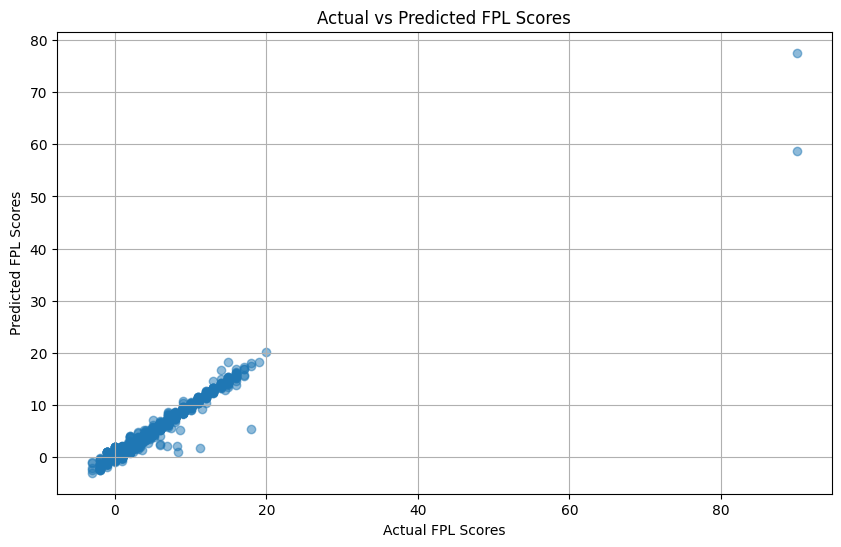

In [12]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs Predicted FPL Scores')
plt.xlabel('Actual FPL Scores')
plt.ylabel('Predicted FPL Scores')
plt.grid(True)
plt.show()

## Analyze Residuals

### Subtask:
Calculate and analyze the residuals of the model's predictions.

**Reasoning**:
Calculate the residuals by subtracting the predicted values from the actual values. Visualize the distribution of the residuals using a histogram and a scatter plot against the predicted values to check for patterns and the spread of errors.

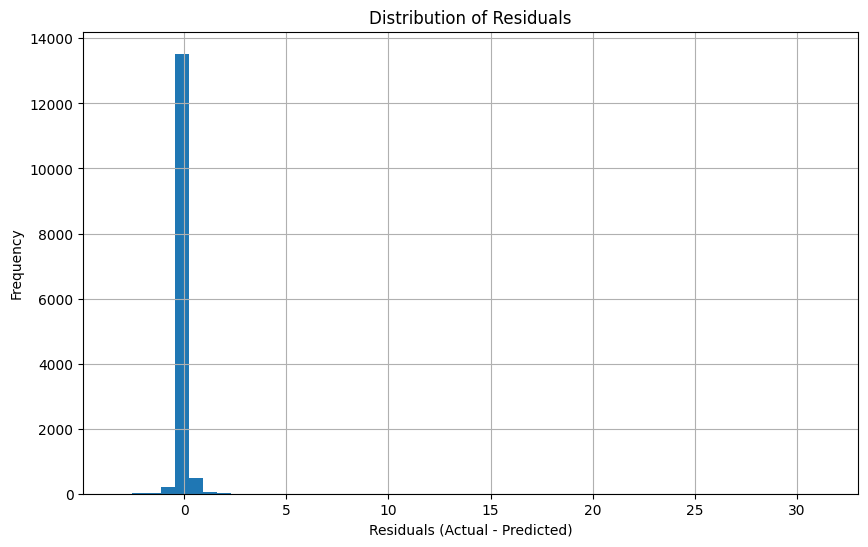

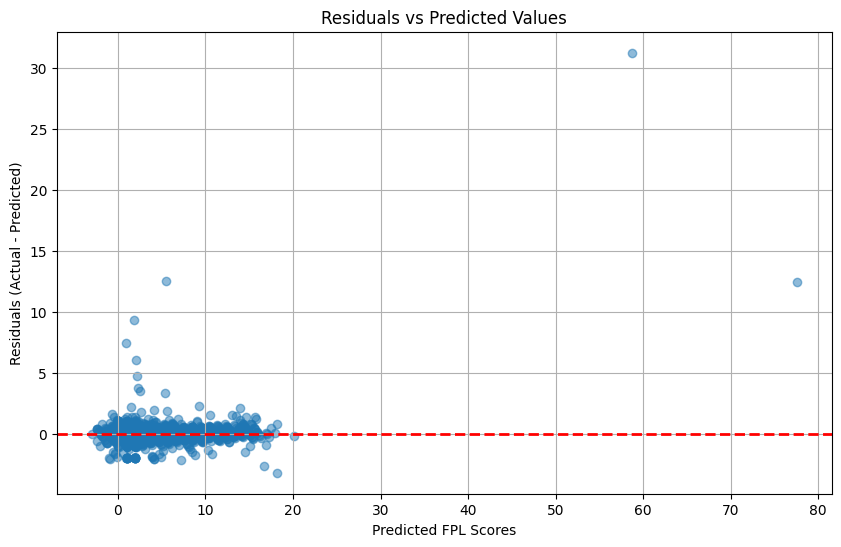

In [13]:
# Calculate residuals
residuals = y_test - predictions

# Plot a histogram of the residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted FPL Scores')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.axhline(0, color='red', linestyle='--', linewidth=2) # Add a horizontal line at 0
plt.show()

## Output results

### Subtask:
Present the predictions and evaluation results in a detailed manner.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Store metrics in a dictionary
metrics = {
    'Test Loss (Mean Squared Error)': loss, # 'loss' is already calculated in the previous cell
    'RMSE': rmse,
    'MAE': mae,
    'R-squared': r2
}

# Display evaluation metrics in the console
print("Model Evaluation Metrics:")
print(f"Test Loss (Mean Squared Error): {metrics['Test Loss (Mean Squared Error)']:.4f}")
print(f"Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
print(f"Mean Absolute Error (MAE): {metrics['MAE']:.4f}")
print(f"R-squared (R²): {metrics['R-squared']:.4f}")

print("\nSample Predictions vs Actual Values:")
# Display the first 10 predictions and actual values in the console
for i in range(10):
    print(f"Predicted: {predictions[i]:.4f}, Actual: {y_test.iloc[i]:.4f}")

Model Evaluation Metrics:
Test Loss (Mean Squared Error): 0.1448
Root Mean Squared Error (RMSE): 0.3805
Mean Absolute Error (MAE): 0.0761
R-squared (R²): 0.9824

Sample Predictions vs Actual Values:
Predicted: 1.9751, Actual: 2.0000
Predicted: 6.8654, Actual: 7.0000
Predicted: 1.0141, Actual: 1.0000
Predicted: 0.0110, Actual: 0.0000
Predicted: 0.0160, Actual: 0.0000
Predicted: 0.0164, Actual: 0.0000
Predicted: -0.1310, Actual: 0.0000
Predicted: 2.0022, Actual: 2.0000
Predicted: 0.0164, Actual: 0.0000
Predicted: 5.9557, Actual: 6.0000


## Display Predictions with Player Information

### Subtask:
Display a DataFrame with Player ID, player name, actual, and predicted FPL scores.

In [18]:
import pandas as pd

# Create a DataFrame from actual and predicted values
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})

# Assuming 'element' in the original df corresponds to player ID
# We need to get the player information for the test set and merge with predictions_df

# Get the original index of the test set
test_indices = y_test.index

# Select the corresponding rows from the original dataframe, including 'player_name'
player_info = df.loc[test_indices, ['element', 'player_name']] # Include 'player_name'

# Merge player_info with predictions_df based on index
predictions_with_info = player_info.merge(predictions_df, left_index=True, right_index=True)

# Rename the 'element' column to 'Player ID'
predictions_with_info = predictions_with_info.rename(columns={'element': 'Player ID'})

# Display the DataFrame with Player ID, player name, actual, and predicted
display(predictions_with_info.head(10))

,Player ID,player_name,Actual,Predicted
43928,456,Jean Michael Seri,2.0,1.975058
70800,225,Victor Lindelöf,7.0,6.865433
19536,421,Ben Foster,1.0,1.014091
52007,337,Steven Davis,0.0,0.010985
64171,145,Leighton Baines,0.0,0.015952
6293,141,Gerard Deulofeu,0.0,0.016364
70715,445,Tyrone Mings,0.0,-0.130962
68991,524,Ryan Sessegnon,2.0,2.002235
65177,128,Martin Kelly,0.0,0.016380
26743,218,Joseph Gomez,6.0,5.955685


## Summary Statistics for Predictions

### Subtask:
Show summary statistics for the predictions_df DataFrame.

In [19]:
# Show summary statistics for the predictions_df DataFrame
display(predictions_df.describe())

,Actual,Predicted
count,14320.000000,14320.000000
mean,1.777718,1.777637
std,2.870557,2.767684
min,-3.000000,-2.941406
25%,0.000000,0.014657
50%,1.000000,1.001504
75%,2.000000,1.996877
max,90.000000,77.537735


## Visualize Training History

### Subtask:
Plot the training and validation loss over epochs.

**Reasoning**:
Plot the training and validation loss from the `history` object to visualize the model's learning process and identify potential overfitting.

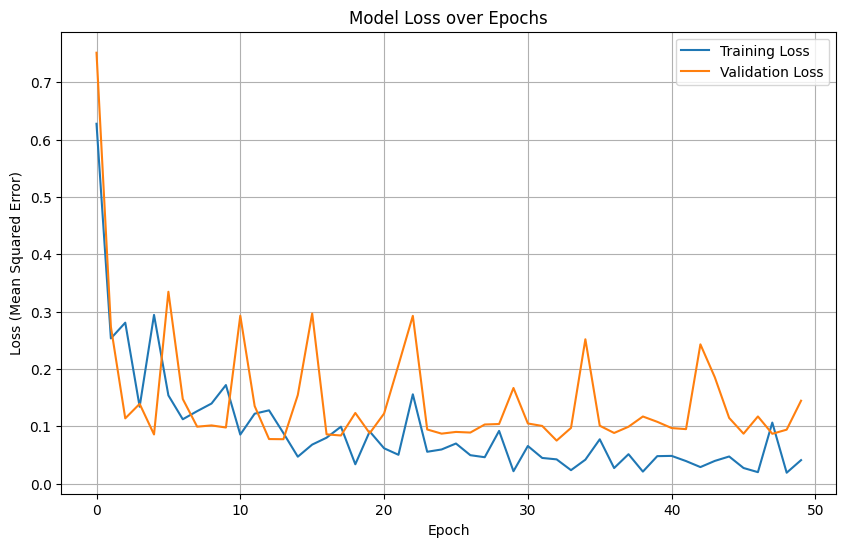

In [20]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

## Save the Model

### Subtask:
Save the trained Keras model.

**Reasoning**:
Save the trained Keras model to a file so it can be loaded and used later without retraining.

In [22]:
# Save the model
model.save('fpl_score_predictor_model.keras')

print("Model saved successfully!")

Model saved successfully!
